# Tree Height Parameter Estimation

In [1]:
import sys,os
from numpy.core.defchararray import asarray
import pandas as pnd
import geopandas as gpd
from shapely import geometry
import rasterio
import rasterio.mask
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from ImageProcessor import RasterOperators, VectorOperators
from shapely.geometry import Point, Polygon ,LineString, mapping
from rasterio.warp import reproject
from rasterio.control import GroundControlPoint
from fiona.crs import from_epsg
import pandas as pnd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
from Others import HeightEstimationUtils as heu
import gdal
import random
from random import randrange, uniform
from fiona.crs import from_epsg
from ProjectConstants import GlobalConstants as gc
import statsmodels.api as sm
from rasterio.plot import show
from matplotlib import pyplot
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

# Read the Reference and the Data shape files

   gen_id  BlockNum     genotype_i
0    2322        10  SCA-10-2322-1
1    2322        10  SCA-10-2322-2
2    2322        10  SCA-10-2322-3
3    2322        10  SCA-10-2322-4
4    2322        10  SCA-10-2322-5


Text(0.5, 1, 'Reference Trees')

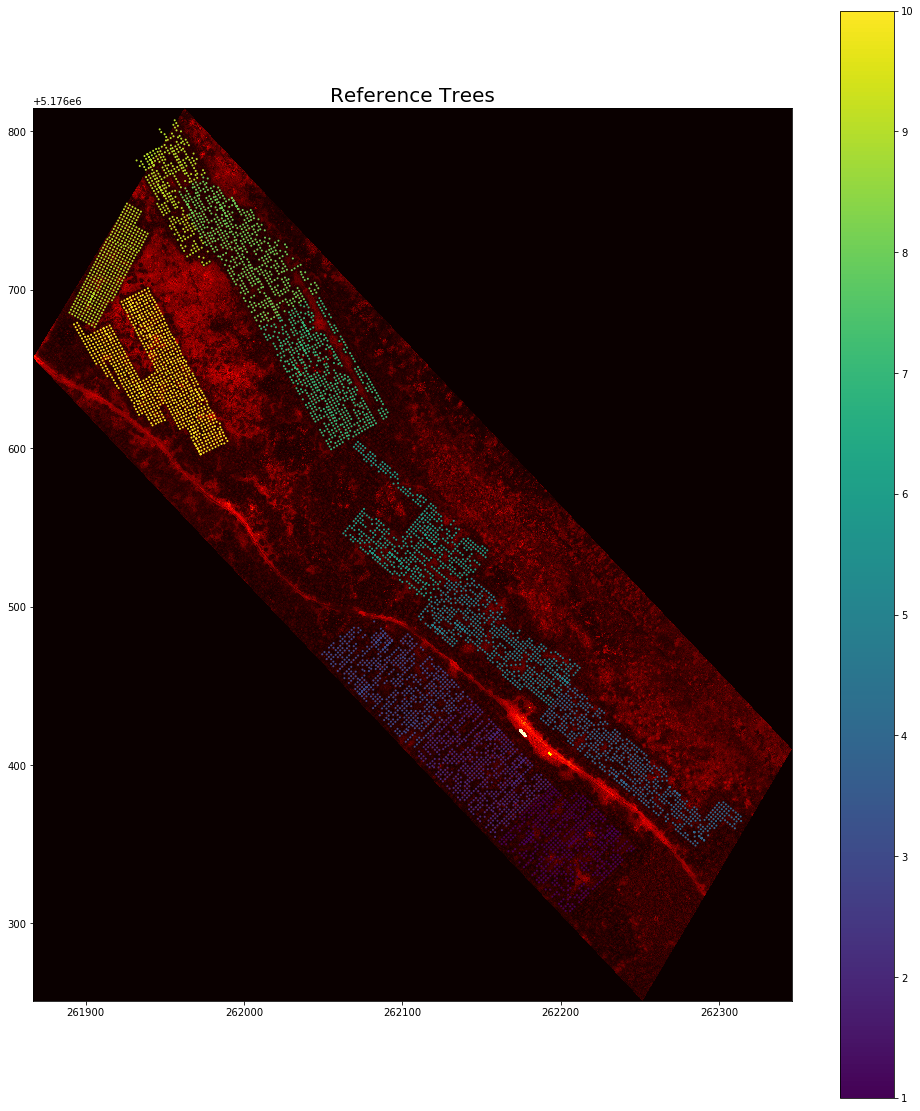

In [2]:
# -- Read the reference data ###
D100TreeRefData = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/Site_info/ReferenceData/StCas_TREE_RS_DATA.shp'
treetopsshp = gpd.read_file(D100TreeRefData)
treetopsshp.rename(columns={"tree_id":"genotype_i"},inplace=True)
# Print Dataset
print(treetopsshp[['gen_id','BlockNum','genotype_i']].head())

# %matplotlib inline
fig, (ax1) = pyplot.subplots(1,1,figsize=(17, 20))
src = rasterio.open('/home/ensmingerlabgpu/Documents/PythonScripts/agisoft_ms_processing/2018MaySC/20180516_4.tif')
show((src,1), transform=src.transform, cmap=plt.get_cmap('hot'), interpolation='nearest', vmin=0, vmax=21354, ax=ax1)
treetopsshp.plot(ax=ax1,column='BlockNum', cmap=None, markersize=1, legend=True)
ax1.set_title('Reference Trees', fontsize=20)

# Localize Tree Tops and Get Tree Height from nDSM

Text(0.5, 1, 'Trees Localized from 20170626 Data')

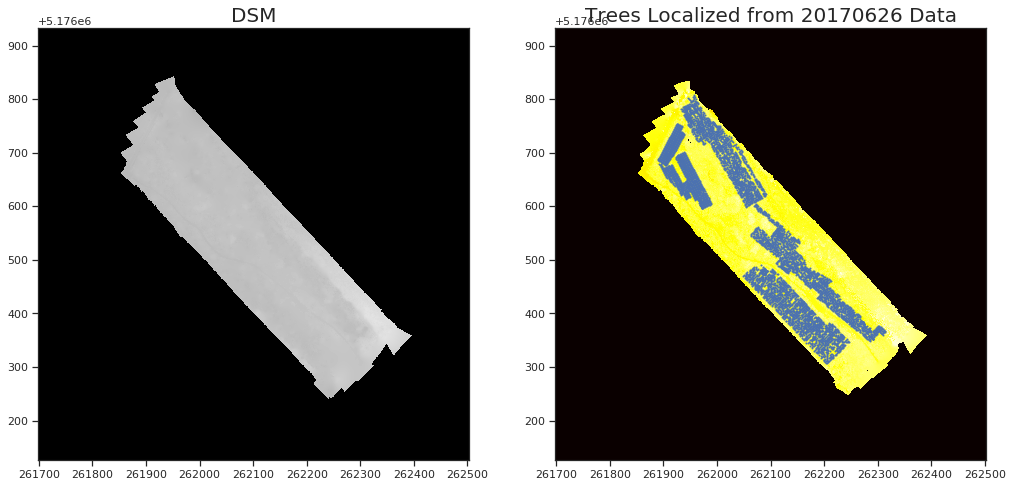

In [94]:
# -- Read DSM file from 20180626 ### 
DEM_Path = '/home/ensmingerlabgpu/Desktop/AgisoftProjects/20170626/DEM.tif'
DSM_Path = '/home/ensmingerlabgpu/Desktop/AgisoftProjects/20170626/DSM.tif'
# -- Read the tree top file from 20180626

fig, (ax1,ax2) = pyplot.subplots(1,2,figsize=(17, 20))
src = rasterio.open(DEM_Path)
show((src,1), transform=src.transform, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0, vmax=73, ax=ax1)
# D1_shp_path.plot(ax=ax,column='BlockNum', cmap=None, markersize=10, legend=True)
# treetopsshp.plot(ax=ax2, markersize=1, legend=False)
ax1.set_title('DEM', fontsize=20)

src = rasterio.open(DSM_Path)
show((src,1), transform=src.transform, cmap=plt.get_cmap('hot'), interpolation='nearest', vmin=0, vmax=73, ax=ax2)
# D1_shp_path.plot(ax=ax,column='BlockNum', cmap=None, markersize=10, legend=True)
treetopsshp.plot(ax=ax2, markersize=1, legend=False)
ax2.set_title('DSM', fontsize=20)

   BlockNum     genotype_i    Height
0        10  SCA-10-2322-1  7.152835
1        10  SCA-10-2322-2  7.345020
2        10  SCA-10-2322-3  8.260065
3        10  SCA-10-2322-4  3.399380
4        10  SCA-10-2322-5  4.751969


Text(0.5, 1, 'Trees Localized from 20170626 Data')

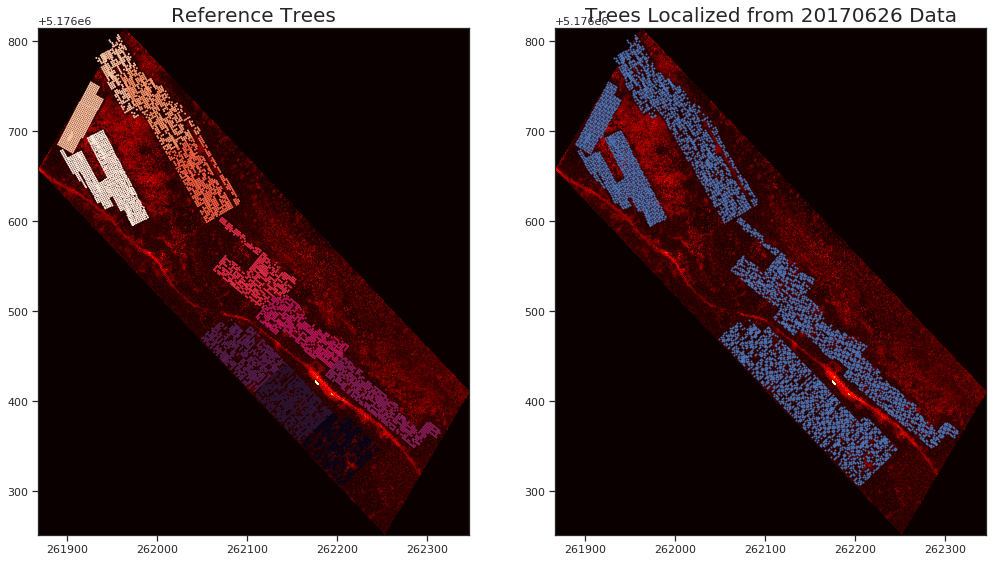

In [95]:
# -- Read DSM file from 20180626 ### 
D1_nDSM_Path = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/nDSM/nDSM.tif'
# -- Read the tree top file from 20180626
D1_shp_path = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/ITC-Data/All-ITC/shapefile_merged.shp'
D1_shp_data = gpd.read_file(D1_shp_path)

HT_DATA_D1D2D3DN= "/home/ensmingerlabgpu/Desktop/AgisoftProjects/ALLSHpHT/ALL.shp"

# Get Proximal Trees
final_gdf_treetop = heu.GetProximalPoints(treetopsshp,D1_shp_data,5)

# Get Tree Height from DSM
meanval_ndvi = heu.GetTreeHeight(final_gdf_treetop, D1_nDSM_Path)
final_gdf_treetop.insert(2, "IDC", [i for i in range(final_gdf_treetop['FID'].count())], True)
data = {'Height':np.array(meanval_ndvi),'IDC':[i for i in range(final_gdf_treetop['FID'].count())]}
testdf = pnd.DataFrame(data)

# Merge rows in the reference and real datasets based on genotype_id
final_gdf_treetop = final_gdf_treetop.merge(testdf, how='inner', on='IDC')
print(final_gdf_treetop[['BlockNum','genotype_i','Height']].head())

# %matplotlib inline
fig, (ax1,ax2) = pyplot.subplots(1,2,figsize=(17, 20))
src = rasterio.open('/home/ensmingerlabgpu/Documents/PythonScripts/agisoft_ms_processing/2018MaySC/20180516_4.tif')
show((src,1), transform=src.transform, cmap=plt.get_cmap('hot'), interpolation='nearest', vmin=0, vmax=21354, ax=ax1)
treetopsshp.plot(ax=ax1,column='BlockNum', cmap=None, markersize=1, legend=False)
ax1.set_title('Reference Trees', fontsize=20)

# %matplotlib inline
src = rasterio.open('/home/ensmingerlabgpu/Documents/PythonScripts/agisoft_ms_processing/2018MaySC/20180516_4.tif')
show((src,1), transform=src.transform, cmap=plt.get_cmap('hot'), interpolation='nearest', vmin=0, vmax=21354, ax=ax2)
# D1_shp_path.plot(ax=ax,column='BlockNum', cmap=None, markersize=10, legend=True)
treetopsshp.plot(ax=ax2, markersize=1, legend=False)
ax2.set_title('Trees Localized from 20170626 Data', fontsize=20)

# Get Tree Height Estimate from nDSM's Digital Number

In [96]:
def getEstimatedHeight(df_in):
    df_in.dropna(inplace=True)
    X = df_in["Height"]
    y = df_in["TreeHeight"]/100
    # Note the difference in argument order
    listvals = list(zip(X,y))
    randlist= random.sample(listvals, k=200)
    tmpFile = gpd.GeoDataFrame(columns=['X','Y'])
    for a, b in randlist:
        tmpFile = tmpFile.append({'X': a, 'Y': b}, ignore_index=True)
    model = sm.OLS(tmpFile['Y'], tmpFile['X'],M=sm.robust.norms.HuberT()).fit()
    print(model.summary())
    return model

In [97]:
# Get height estimate from DSM DN value

# Remove outliers
# q_low = final_gdf_treetop["Height"].quantile(0.10)
# q_hi  = final_gdf_treetop["Height"].quantile(0.90)
# final_gdf_treetop = final_gdf_treetop[(final_gdf_treetop["Height"] < q_hi) & (final_gdf_treetop["Height"] > q_low)]

# Model relationship
model = getEstimatedHeight(final_gdf_treetop)
height_estimates_from_dn = model.predict(final_gdf_treetop['Height'])

# add estimated height as the last column in the Dataframe
final_gdf_treetop['HeightEst'] = height_estimates_from_dn
final_gdf_treetop["TreeHeightInMeters"] = final_gdf_treetop["TreeHeight"]/100 # convert to meters

final_gdf_treetop["Forest_ID"] = [i*0+1 for i in range(final_gdf_treetop["BlockNum"].count())]
print(final_gdf_treetop[['BlockNum','genotype_i','TreeHeightInMeters','HeightEst']].head())

#     outshpfile = '/home/ensmingerlabgpu/Desktop/AgisoftProjects/20170626/Estimates/Height/Ref_Trees/refdata.shp'
#     final_gdf_treetop.to_file(driver= 'ESRI Shapefile', filename = outshpfile)

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              3178.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                   2.55e-124
Time:                        11:46:49   Log-Likelihood:                         -455.41
No. Observations:                 200   AIC:                                      912.8
Df Residuals:                     199   BIC:                                      916.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

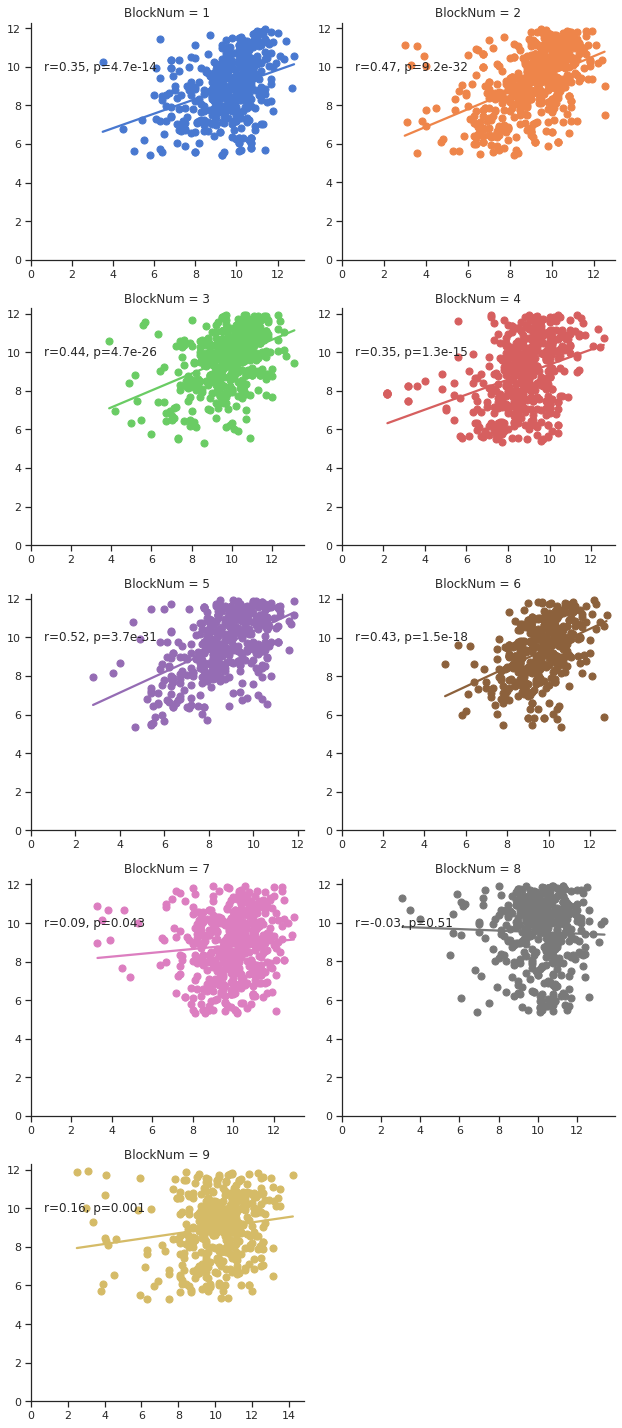

In [82]:
sns.set(style="ticks")
df = final_gdf_treetop[['BlockNum','TreeHeightInMeters','HeightEst','Forest_ID']]

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="TreeHeightInMeters", y="HeightEst", col="BlockNum", hue="BlockNum", data=df,
           col_wrap=2, ci=None, palette="muted", height=4, aspect=1.1, fit_reg=True, sharex=False,sharey=False,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, None))
g.set(xlim=(0, None))
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['TreeHeightInMeters'], data['HeightEst'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
#     ax.set_ylim(0,)
#     ax[0,1].set_ylim(0,)
    
g.map_dataframe(annotate)